# Showcase for fairness metrics with loan dataset

## imports

In [21]:
import csv
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import plot_model
from holisticai.bias.metrics import statistical_parity, accuracy_diff

<br>

## load dataset

In [2]:
source_df = pd.read_csv('biased_gender_loans.csv')
display(source_df)

,salary,years_exp,sex,bank_loan
0,1107,19,Woman,No
1,1267,10,Woman,No
2,896,19,Woman,No
3,1226,16,Woman,No
4,1207,19,Woman,No
...,...,...,...,...
9995,1326,22,Woman,No
9996,1303,14,Woman,No
9997,1786,24,Man,Yes
9998,1351,13,Woman,No


<br>

## Distribution of Data

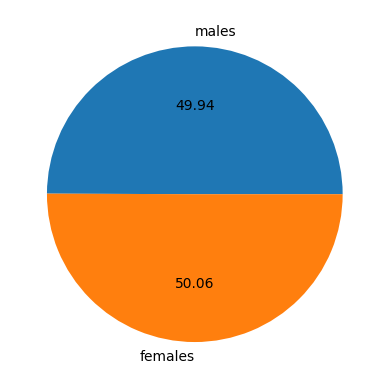

In [3]:
# How many females & males in Dataset

female_count = len(source_df[source_df['sex'] == "Woman"])
male_count = len(source_df[source_df['sex'] == "Man"])
piechart_array = np.array([male_count, female_count])
labels = ["males", "females"]
plt.pie(piechart_array, labels = labels, autopct='%.2f')
plt.show() 

#### Bias metric group imbalance

In [4]:
def group_imbalance(df, g1_mask, g2_mask):
    n_g1 = g1_mask.sum()
    n_g2 = g2_mask.sum()
    gi = (n_g1 - n_g2)/(n_g1+n_g2)
    return gi

g1_mask = (source_df['sex'] == "Man")
g2_mask = (source_df['sex'] == "Woman")

print("Group imbalance =",group_imbalance(source_df, g1_mask, g2_mask))
print("Group imbalance ranges form -1 to 1. Group imbalance near 0 is desired")

Group imbalance = -0.0012
Group imbalance ranges form -1 to 1. Group imbalance near 0 is desired


<br>

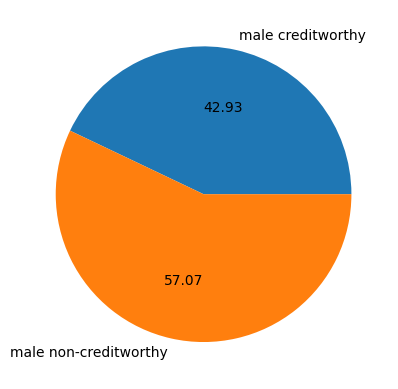

In [5]:
# show male distribution in positive / negative credit labels

male_count_positive = len(source_df[(source_df['sex'] == "Man") & (source_df['bank_loan'] == "Yes")])
male_count_negative = len(source_df[(source_df['sex'] == "Man") & (source_df['bank_loan'] == "No")])
piechart_array = np.array([male_count_positive, male_count_negative])
labels = ["male creditworthy", "male non-creditworthy"]
plt.pie(piechart_array, labels = labels, autopct='%.2f')
plt.show() 

<br>

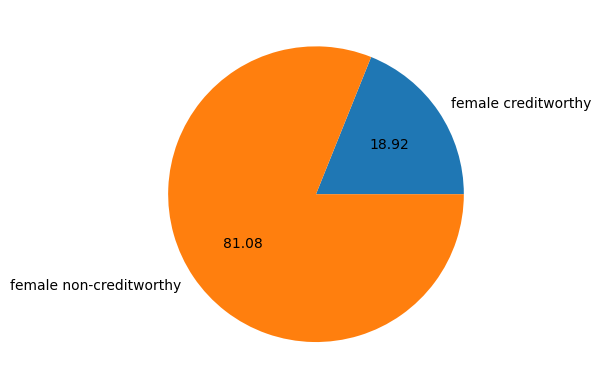

In [6]:
# show female distribution in positive / negative credit labels

female_count_positive = len(source_df[(source_df['sex'] == "Woman") & (source_df['bank_loan'] == "Yes")])
female_count_negative = len(source_df[(source_df['sex'] == "Woman") & (source_df['bank_loan'] == "No")])
piechart_array = np.array([female_count_positive, female_count_negative])
labels = ["female creditworthy", "female non-creditworthy"]
plt.pie(piechart_array, labels = labels, autopct='%.2f')
plt.show() 

<br>

#### Bias metrics DPL (different proportions of labels)

In [7]:
def different_proportions_of_labels(df, g1_mask, g2_mask, predict_feature):
    g1_df = df[g1_mask]
    g2_df = df[g2_mask]
    count_g1_p = len(g1_df[df[predict_feature] == "Yes"])
    count_g1_n = len(g1_df[df[predict_feature] == "No"])
    count_g2_p = len(g2_df[df[predict_feature] == "Yes"])
    count_g2_n = len(g2_df[df[predict_feature] == "No"])

    dpl = (count_g1_p/count_g1_n) - (count_g2_p/count_g2_n)

    return dpl

g1_mask = (source_df['sex'] == "Man")
g2_mask = (source_df['sex'] == "Woman")

print("DPL =", different_proportions_of_labels(source_df, g1_mask, g2_mask, "bank_loan"))
print("DPL ranges from -1 to 1. If DPL is close enough to 0, then we say that demographic parity has been achieved.")
print("\n\n")

DPL = 0.5189720050310551
DPL ranges from -1 to 1. If DPL is close enough to 0, then we say that demographic parity has been achieved.





/var/folders/hw/f68q54vd4mdf5htjrhfn6vs80000gp/T/ipykernel_1840/3545592796.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_g1_p = len(g1_df[df[predict_feature] == "Yes"])
/var/folders/hw/f68q54vd4mdf5htjrhfn6vs80000gp/T/ipykernel_1840/3545592796.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_g1_n = len(g1_df[df[predict_feature] == "No"])
/var/folders/hw/f68q54vd4mdf5htjrhfn6vs80000gp/T/ipykernel_1840/3545592796.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_g2_p = len(g2_df[df[predict_feature] == "Yes"])
/var/folders/hw/f68q54vd4mdf5htjrhfn6vs80000gp/T/ipykernel_1840/3545592796.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_g2_n = len(g2_df[df[predict_feature] == "No"])


## Data Preprocessing

In [8]:
# split input / target
df_without_y = source_df.drop('bank_loan', axis='columns')
df_only_y = source_df.filter(['bank_loan'])

# Fixing categorical variables
df_without_y['sex'] = (df_without_y['sex'] == "Woman").astype(int)
df_only_y['bank_loan'] = (df_only_y['bank_loan'] == "Yes").astype(int)

# train / test split
x_train, x_test, y_train, y_test = train_test_split(df_without_y, df_only_y, test_size=0.2)

display(x_train)
display(y_train)
# standardization of input
scaler = StandardScaler()
scaled_xtrain, scaled_xtest = scaler.fit_transform(x_train), scaler.fit_transform(x_test)

# target needs to be transformed to np array (for input happens behind the scenes by scaler)
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

display(scaled_xtrain.shape)
display(y_train.shape)


,salary,years_exp,sex
9578,1416,27,1
2601,1879,28,0
24,989,26,1
771,1577,12,1
2461,1808,14,1
...,...,...,...
6402,1597,13,1
7119,1679,22,0
340,1182,18,0
8648,1443,15,0


,bank_loan
9578,0
2601,1
24,0
771,0
2461,0
...,...
6402,0
7119,1
340,0
8648,0


(8000, 3)

(8000, 1)

<br>

## Model Training on biased Dataset

In [9]:
# defining a simple DL model with X hidden layers using the TF Keras functional API

# define the layers
input_layer = Input(shape=(3,))
hidden1 = Dense(10, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(5, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden2 = Dense(2, activation='relu')(dropout2)
output = Dense(1, activation='sigmoid')(hidden2)

# train model with unchanged dataset
model = Model(inputs=input_layer, outputs=output)

2024-05-07 08:55:48.283442: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-07 08:55:48.283465: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-07 08:55:48.283469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-07 08:55:48.283658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 08:55:48.283669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


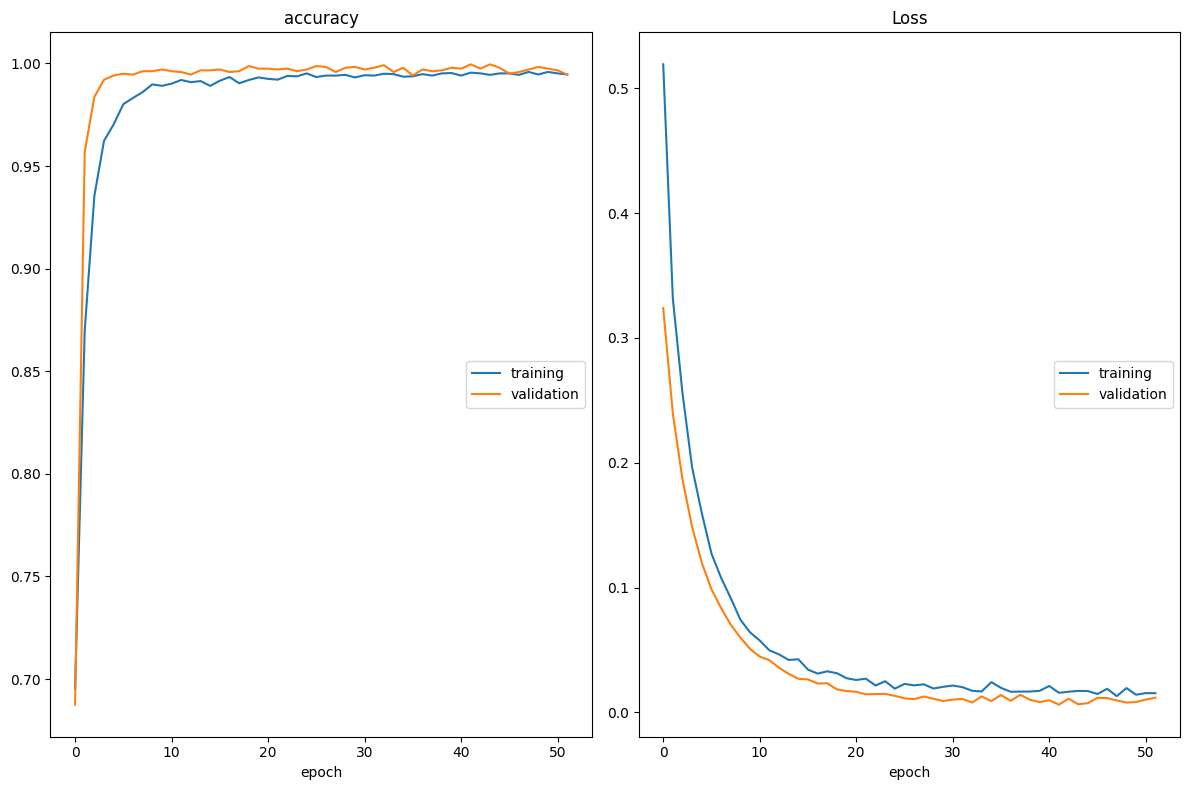

accuracy
	training         	 (min:    0.695, max:    0.996, cur:    0.995)
	validation       	 (min:    0.688, max:    1.000, cur:    0.995)
Loss
	training         	 (min:    0.013, max:    0.519, cur:    0.015)
	validation       	 (min:    0.006, max:    0.324, cur:    0.012)
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9946 - val_loss: 0.0118


In [10]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# create early stopping monitor - will stop training 5 epochs after no improvement in val_loss
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 10)

# fit model
model.fit(scaled_xtrain, y_train, validation_split=0.3, batch_size=16, epochs=1000, callbacks=[PlotLossesKeras(), monitor_val_acc])

<br>

## Evaluation of predictions with focus on data cohorts

### util functions

In [11]:
def create_barchart_threshold_line(x, y, threshold=0):
    
    display(x)
    display(y)
    x = np.array(x)
    values = np.array(y)
    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    
    a_threshold = np.maximum(values - threshold, 0)
    b_threshold = np.minimum(values, threshold)
    
    fig, ax = plt.subplots()
    ax.bar(x, b_threshold, 0.35, color="blue")
    ax.bar(x, a_threshold, 0.35, color="yellow", bottom=b_threshold)
    
    plt.axhline(threshold, color='red', ls='dotted')
    return plt

### Data preparation

In [12]:
# show metric results with model trained on unchanged dataset
predictions = model.predict(scaled_xtest)
predictions_bool = (predictions>=0.5).astype(int).flatten()

group_women_bool_train = (x_train.to_numpy()[:, 2])
group_man_bool_train = (x_train.to_numpy()[:, 2]==0).astype(int)

group_women_bool_test = (x_test.to_numpy()[:, 2])
group_man_bool_test = (x_test.to_numpy()[:, 2]==0).astype(int)

y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

display(predictions.shape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(2000, 1)

### Statistical parity

'statistical parity training dataset: -0.24008891700618995'

'statistical parity predictions on test set: -0.2535584740462789'

['statistical parity training dataset',
 'statistical parity predictions on test set']

[-0.24008891700618995, -0.2535584740462789]

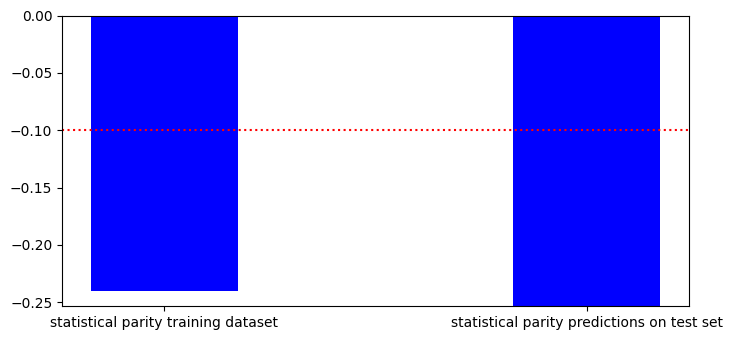

In [13]:
# A value of 0 is desired. Negative values are unfair towards group_a (females). 
# Positive values are unfair towards group_b (males). The range (-0.1,0.1) is considered acceptable.
statistical_parity_dataset = statistical_parity(group_women_bool_train, group_man_bool_train, y_train_flat)
statistical_parity_predictions = statistical_parity(group_women_bool_test, group_man_bool_test, predictions_bool)

display("statistical parity training dataset: " + str(statistical_parity_dataset))
display("statistical parity predictions on test set: " + str(statistical_parity_predictions))

barplot = create_barchart_threshold_line(["statistical parity training dataset", "statistical parity predictions on test set"], 
                               [statistical_parity_dataset, statistical_parity_predictions],
                              threshold=-0.1)
barplot.show()

<br>

### Accuracy Diff

array([0, 1, 1, ..., 1, 1, 1])

array([1, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

-0.01048155096935588

['accuracy diff']

[-0.01048155096935588]

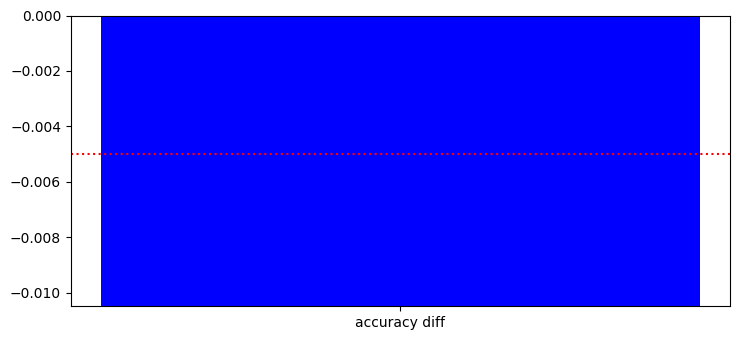

In [28]:
# A value of 0 is desired. This metric ranges between -1 and 1.
# with negative values indicating bias against group_a (female), and positive values indicating bias against group_b (male)

display(group_women_bool_test)
display(group_man_bool_test)
display(predictions_bool)
display(y_test_flat)
accuracy_diff_score = accuracy_diff(group_women_bool_test, group_man_bool_test, predictions_bool, y_test_flat)
display(accuracy_diff_score)
accuracy_diff_barchart = create_barchart_threshold_line(["accuracy diff"], [accuracy_diff_score], threshold=-0.005)

<br>

## train model without gender

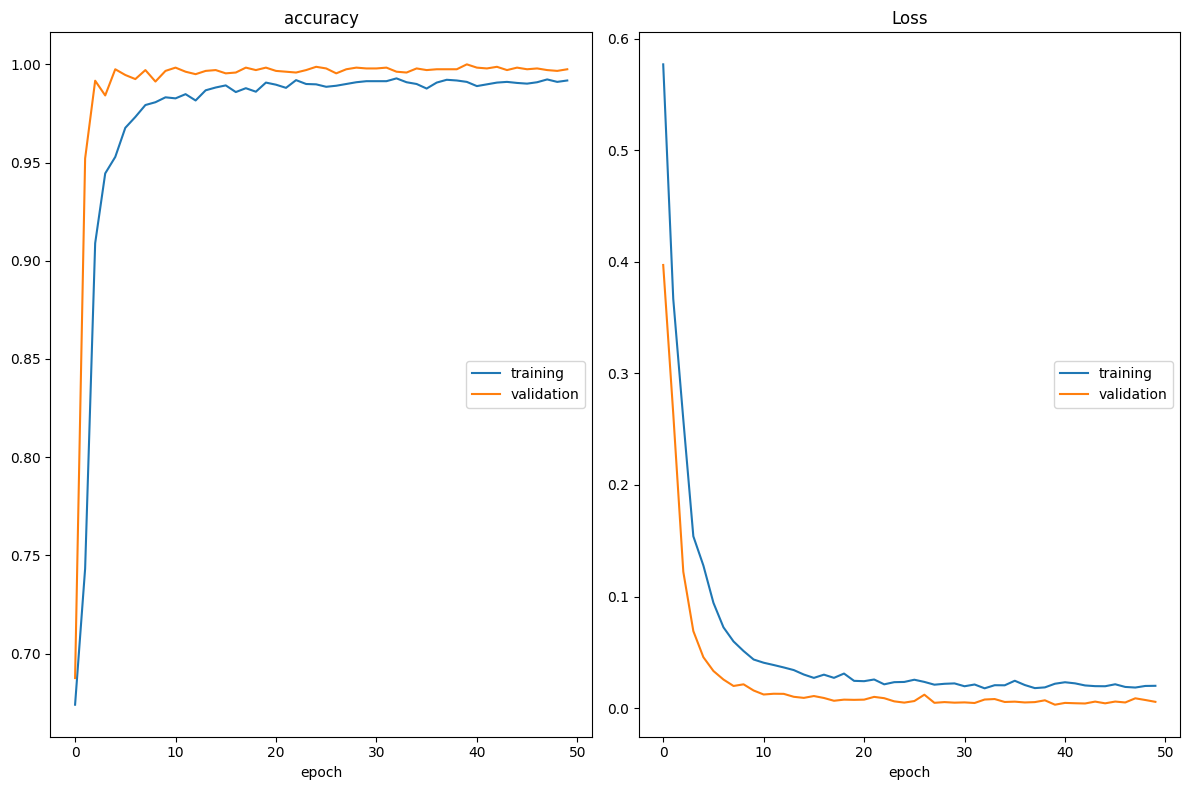

accuracy
	training         	 (min:    0.674, max:    0.993, cur:    0.992)
	validation       	 (min:    0.688, max:    1.000, cur:    0.998)
Loss
	training         	 (min:    0.018, max:    0.577, cur:    0.020)
	validation       	 (min:    0.003, max:    0.397, cur:    0.006)
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9917 - loss: 0.0207 - val_accuracy: 0.9975 - val_loss: 0.0056


In [15]:
x_train_no_gender = scaled_xtrain[:, :2]

display(x_train_no_gender)

# defining a simple DL model with X hidden layers using the TF Keras functional API

# define the layers
input_layer_model2 = Input(shape=(3,))
hidden1_model2 = Dense(10, activation='relu')(input_layer_model2)
dropout1_model2 = Dropout(0.2)(hidden1_model2)
hidden2_model2 = Dense(5, activation='relu')(dropout1_model2)
dropout2_model2 = Dropout(0.2)(hidden2_model2)
hidden3_model2 = Dense(2, activation='relu')(dropout2_model2)
output_model2 = Dense(1, activation='sigmoid')(hidden3_model2) 

# re-instantiate model for training without gender
model_no_gender = Model(inputs=input_layer_model2, outputs=output_model2)

# compile the model
model_no_gender.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# create early stopping monitor - will stop training 5 epochs after no improvement in val_loss
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 10)

# fit model
model_no_gender.fit(scaled_xtrain, y_train, validation_split=0.3, batch_size=16, epochs=1000, callbacks=[PlotLossesKeras(), monitor_val_acc])

<br>

### Compare accuracy of models

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


'accuracy Model 1 (with Gender): 0.9895'

'accuracy Model 2 (with Gender): 0.9855'

['accuracy Model w/ Gender', 'accuracy Model w/o Gender']

[0.9895, 0.9855]

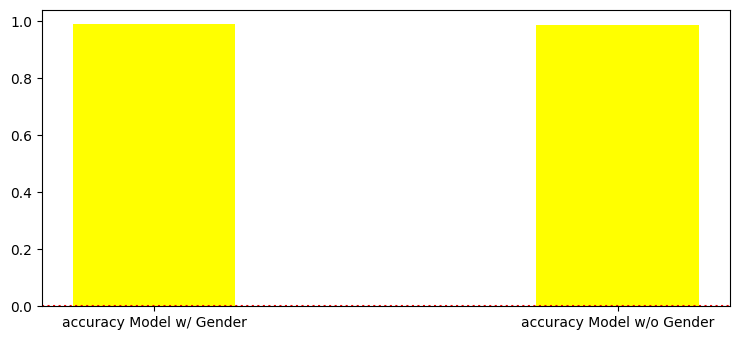

In [25]:
# Compare accuracy between first model (with gender) and second model (without gender)

predictions_model2 = model_no_gender.predict(scaled_xtest)
predictions_bool_model2 = (predictions_model2>=0.5).astype(int).flatten()

# show accuracy difference between both models
test_accuracy_model1 = accuracy_score(y_test_flat, predictions_bool)
test_accuracy_model2 = accuracy_score(y_test_flat, predictions_bool_model2)

display("accuracy Model 1 (with Gender): " + str(test_accuracy_model1))
display("accuracy Model 2 (with Gender): " + str(test_accuracy_model2))

accuracy_barchart_model_comparison = create_barchart_threshold_line(["accuracy Model w/ Gender", "accuracy Model w/o Gender"], 
                                                                    [test_accuracy_model1, test_accuracy_model2], threshold=0.0)

<br>

-0.0022764227642276813

['accuracy diff Model1', 'accuracy diff Model2']

[-0.01048155096935588, -0.0022764227642276813]

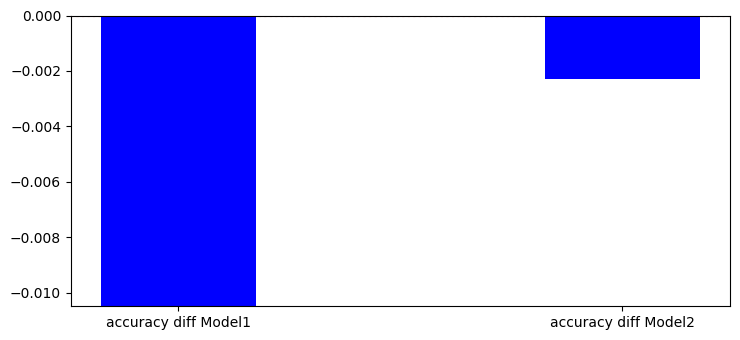

In [31]:
# show accuracy diff metric

accuracy_diff_score_model2 = accuracy_diff(group_women_bool_test, group_man_bool_test, predictions_bool_model2, y_test_flat)
display(accuracy_diff_score_model2)
accuracy_diff_barchart_model2 = create_barchart_threshold_line(["accuracy diff Model1", "accuracy diff Model2"], 
                                                               [accuracy_diff_score, accuracy_diff_score_model2], threshold=-0.0)

'statistical parity Model 1: -0.2535584740462789'

'statistical parity Model 2: -0.24135084427767356'

['statistical parity Model1', 'statistical parity Model2']

[-0.2535584740462789, -0.24135084427767356]

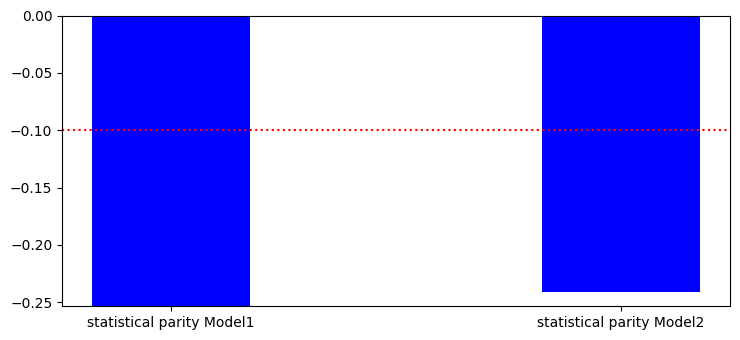

In [33]:
# Show statisctical parity comparison between the 2 models
# A value of 0 is desired. Negative values are unfair towards group_a (females). 
# Positive values are unfair towards group_b (males). The range (-0.1,0.1) is considered acceptable.

statistical_parity_predictions_model1 = statistical_parity(group_women_bool_test, group_man_bool_test, predictions_bool)
statistical_parity_predictions_model2 = statistical_parity(group_women_bool_test, group_man_bool_test, predictions_bool_model2)

display("statistical parity Model 1: " + str(statistical_parity_predictions_model1))
display("statistical parity Model 2: " + str(statistical_parity_predictions_model2))

barplot_sp_comparison = create_barchart_threshold_line(["statistical parity Model1", "statistical parity Model2"], 
                               [statistical_parity_predictions_model1, statistical_parity_predictions_model2],
                              threshold=-0.1)
barplot_sp_comparison.show()